# imports

In [1]:
# scraping
import requests
from bs4 import BeautifulSoup

In [2]:
# data
import pandas as pd
# import dtale as dt
import plotly.express as px
# from wordcloud import WordCloud, STOPWORDS

In [3]:
# string manipulation
import re
import string
from collections import Counter 

In [4]:
# stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [5]:
from html.parser import HTMLParser

class HTMLFilter(HTMLParser):
    text = ""
    def handle_data(self, data):
        self.text += data

In [6]:
import chart_studio.plotly as py
import chart_studio.tools as tls
import chart_studio
import os
chart_studio.tools.set_credentials_file(username=os.environ.get('CHART_STUDIO_USERNAME'), api_key=os.environ.get('CHART_STUDIO_KEY'))

## Wordcloud

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np


In [8]:
from PIL import Image
import requests
from io import BytesIO


In [9]:
response = requests.get('https://shop.digitemb.com/wp-content/uploads/2019/06/V-20803-The-Poltimore-King-Crown-Silhouette-Vector-Art.jpg')
crown_mask = np.array(Image.open(BytesIO(response.content)).convert('L'))

crown_mask = crown_mask[~np.all(crown_mask==255, axis=0)]
crown_mask = crown_mask[~np.all(crown_mask==255, axis=1)]


# setting everything up

In [10]:
# create custom stop words list
all_stopwords = stopwords.words('english')
all_stopwords = [a.lower() for a in all_stopwords]
all_stopwords.extend(['i', 'us','we'])

# initialise translator to remove punctuation from strings
translator = str.maketrans('', '', string.punctuation)

# functions

In [11]:
def make_wordcloud(d, mask=crown_mask):

    wc = WordCloud(
        background_color='white',
        mask=mask,
        colormap='RdYlGn'
    )
    # generate the word cloud
    wc.generate_from_frequencies(frequencies=d)

    fig = plt.figure(dpi=300)

    # display the word cloud
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    
    return plt

# scrape

In [12]:
# function to get webpage text from url
def get_text_from_url(url, year):
    
    a = (requests.get(url).content)
    
    start = 'Published 23 December 2019</div><p>' if year == 2019 else '</blockquote><p>'

    try:
        text = re.search(bytes('{}(.*?)Share this article:'.format(start), encoding='utf8'), a, flags=re.S).group(1)
    except AttributeError:
        return ''

    text = re.sub(b"<em>(.*?)</em>", b'', text)
    
    f = HTMLFilter()

    f.feed(text.decode("utf-8").replace('\n',' '))
            
    return re.sub(r'[^\w\s]','',f.text).replace(u'\xa0', ' ')


In [13]:
# function to get webpage text from url
def get_raw_text_from_url(url, year):
    
    a = (requests.get(url).content)
    
    start = 'Published 23 December 2019</div><p>' if year == 2019 else '</blockquote><p>'

    try:
        text = re.search(bytes('{}(.*?)Share this article:'.format(start), encoding='utf8'), a, flags=re.S).group(1)
    except AttributeError:
        return ''

    text = re.sub(b"<em>(.*?)</em>", b'', text)

    f = HTMLFilter()

    f.feed(text.decode("utf-8"))
            
    return f.text.replace(u'\xa0', ' ')


In [147]:
# initialising variable
speech = {}
all_speeches_d = {}

# all potential url page names
page_names = ['queens-first-christmas-broadcast-','christmas-broadcast-','queen’s-christmas-broadcast-', 'queens-christmas-broadcast']

df = pd.DataFrame(columns=['counts', 'year'])

# iterate through all years we have queen's speeches for
for year in range(1952, 2020+1):
# for year in range(1988, 1989+1):
        
    # trying all page names
    for page_name in page_names:
        
        # set url
        url = 'https://www.royal.uk/' + page_name + str(year)
        
        # getting text from url
        web_text = get_text_from_url(url, year) #.replace(u'\xa0', u' ')  
    
        
        # if the page is found don't try the other page names
        if web_text:
            # print('waa waa wee waa')
            break
        
        # if we get no results from all three page names, make sure text is empty
        if page_name == page_names[-1]:
            web_text = ''
           
    # print(web_text)
    
    # web_text = web_text.translate(str.maketrans('', '', string.punctuation))

    # web_text = re.sub(r'[^\w\s]','',web_text)
    
    all_speeches_d[year] = get_raw_text_from_url(url, year)

                    
    # print('{}: {}'.format(year, len(web_text)))
       
    # remove stopwords, convert to lower case and store in dictionary
    # speech[year] = [[word.lower() for word in word_tokenize(web_text) if (not word.lower() in all_stopwords) and len(word) > 1]]
    
    curr_series = pd.DataFrame(pd.Series([word.lower() for word in word_tokenize(web_text) if (not word.lower() in all_stopwords) and len(word) > 1]).value_counts(),
                               columns=['counts'])
    
    curr_series['year'] = year
    
    df = df.append(curr_series)
    
    
all_speeches = '\n\n'.join(str(x) for x in all_speeches_d.values())

df = df.reset_index().rename(columns={'index': 'word'}).sort_values(['counts', 'year'], ascending=False).astype({'counts': np.int, 'year': np.int})

df

,word,counts,year
6515,commonwealth,14,1982
5425,future,14,1978
6212,courage,12,1981
5749,children,12,1979
14972,christmas,11,2015
...,...,...,...
240,exchanging,1,1952
241,ten,1,1952
242,since,1,1952
243,members,1,1952


In [148]:
with open("outputs/all_speeches.txt", "w") as text_file:
    text_file.write(all_speeches)

# functions

In [149]:
def fill_0(loc_df):
    for year in df['year'].unique():
        for word in loc_df['word'].unique():
            if not len(loc_df[(loc_df['word'] == word) & (loc_df['year'] == year)]):
                loc_df = loc_df.append(pd.DataFrame({'word': [word], 'counts': [0], 'year': year}))
                            
    return loc_df.sort_values('year', ascending=False)

In [150]:
def top_by_total(start=1900, end=2025):
    return df[(df['year'] >= start) & (df['year'] <= end)][['word','counts']].groupby('word').sum().sort_values('counts', ascending=False).reset_index()
    

In [151]:
def top_by_consist(start=1900, end=2025):
    return df[(df['year'] >= start) & (df['year'] <= end)]['word'].value_counts()
    

In [152]:
def words_in(words, start=1900, end=2025):
    if isinstance(words, list):
        return df[(df['year'] >= start) & (df['year'] <= end)][df['word'].isin(words)]
    
    elif isinstance(words, pd.Series):
        return df[(df['year'] >= start) & (df['year'] <= end)][df['word'].isin(words.index)]

    else:
        return df[(df['year'] >= start) & (df['year'] <= end)][df['word'].isin(words['word'])]


In [153]:
top_by_consist().head(10)

christmas       69
people          66
year            64
happy           63
many            63
time            61
world           61
commonwealth    59
one             57
great           53
Name: word, dtype: int64

In [154]:
def bingo_WL(words, start=1900, end=2030):

    loc_df = words_in(words, start=start, end=end)

    succ = fill_0(loc_df)[['year','counts']].groupby('year').agg('min').sort_values('counts')
        
    succ = succ[(succ.index >= start) & (succ.index <= end)]
    
    return (succ[succ['counts'] > 0].index,
            succ[succ['counts'] == 0].index
           )
    

In [155]:
def bingo_success(words, start=1900, end=2030, percent = True):
    succ = bingo_WL(words, start=start, end=end)
    
    if percent:
        return (len(succ[0]) / (len(succ[0]) + len(succ[1])))
    else:
        return (len(succ[0]), len(succ[0]) + len(succ[1]))
    

## EDA

In [156]:
top_by_total().head(10)

,word,counts
0,christmas,315
1,people,231
2,year,220
3,world,208
4,many,197
5,commonwealth,179
6,one,145
7,time,135
8,family,123
9,great,117


In [157]:
top_by_total(end=1959).head(10)

,word,counts
0,christmas,42
1,commonwealth,29
2,new,26
3,year,25
4,world,24
5,family,21
6,people,20
7,may,20
8,great,19
9,day,17


In [158]:
top_by_total(start=2009).head(10)

,word,counts
0,christmas,61
1,many,47
2,people,45
3,year,41
4,world,34
5,family,29
6,commonwealth,29
7,time,26
8,love,21
9,great,21


## late and early words

In [159]:
late_df = words_in(top_by_total()[top_by_total()['counts'] >= 20])

late_df = late_df[['word','year']].groupby('word').min().reset_index().sort_values('year', ascending=False).head()

late_df

,word,year
4,anniversary,1982
86,jesus,1979
138,reconciliation,1976
22,christ,1973
117,news,1970


In [160]:
early_df = words_in(top_by_total()[top_by_total()['counts'] >= 10])

early_df = early_df[['word','year']].groupby('word').max().reset_index().sort_values('year', ascending=True).head()

early_df

,word,year
39,brotherhood,1982
460,wishes,1987
361,send,1989
114,everything,1991
163,grandfather,1992


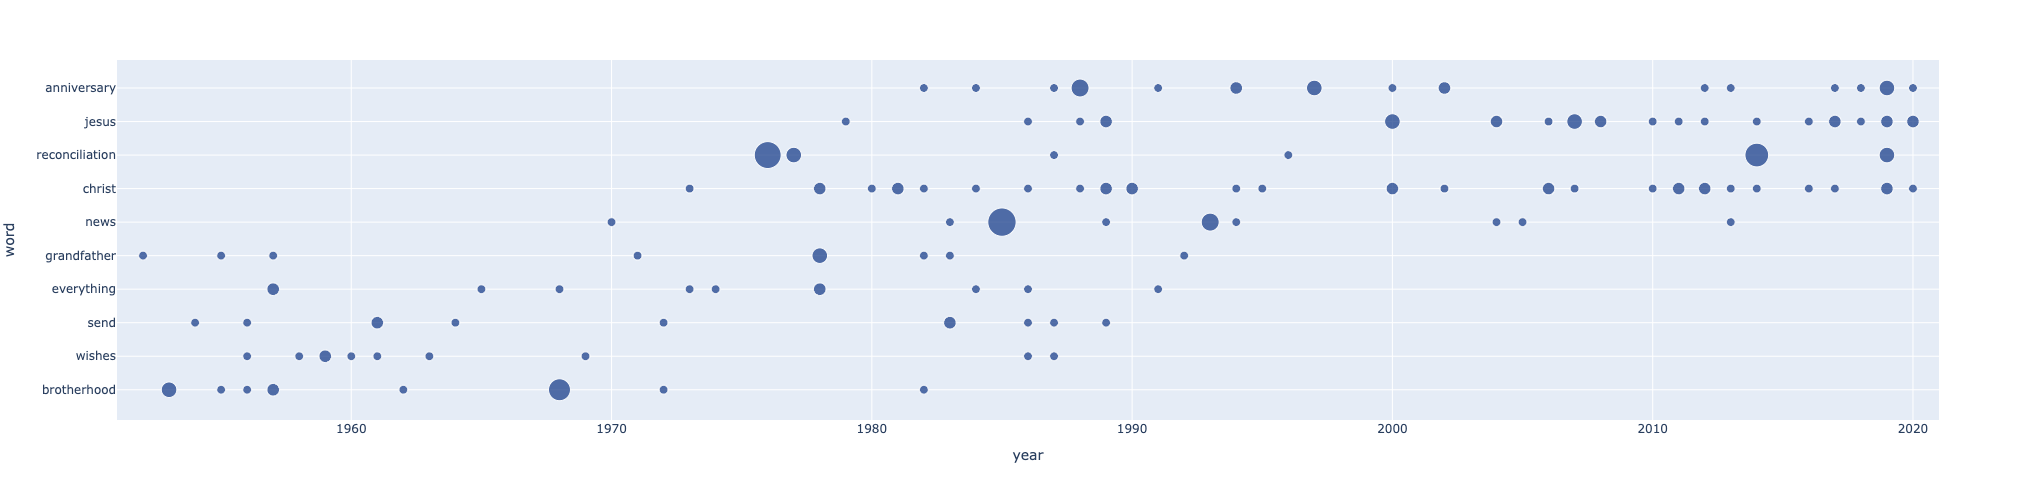

In [161]:
all_total_plt = plot_heat(early_df.append(late_df),
                         order=early_df.sort_values('year').append(late_df.sort_values('year'))['word'].values)

all_total_plt

In [162]:
df.groupby('word').sum().sort_values('year')

,counts,year
word,,
exchanging,1,1952
dedicate,1,1952
solemn,1,1952
broad,1,1952
anew,1,1952
...,...,...
many,197,125112
happy,92,125225
year,220,127101


In [237]:
agg_df = df.groupby('word').agg({'year': [min, max], 'counts': sum}).reset_index() #.sort_values('year', ascending=True).head()
agg_df.columns = ['word', 'year min', 'year max', 'counts']

agg_df 

,word,year min,year max,counts
0,100th,2018,2018,1
1,11,2019,2019,1
2,13000,2009,2009,1
3,14,2018,2018,1
4,147,2016,2016,1
...,...,...,...,...
4507,youve,1989,1989,2
4508,zealand,1953,2016,15
4509,zealanders,1970,1983,2
4510,zimbabwe,1991,1991,1


In [238]:
from IPython.core.display import display, HTML

def force_show_all(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
        display(HTML(df.to_html()))


In [239]:
late_df = agg_df.iloc[agg_df.groupby('year min')['counts'].idxmax()].set_index('word').drop('year max', axis=1)

# force_show_all(late_df)

In [240]:
old_len = len(late_df.index) + 1
while old_len - len(late_df.index) > 0:
    old_len = len(late_df.index)
    late_df = late_df[late_df['counts'].diff(-1).fillna(1) > 0]


late_df

,year min,counts
word,,
christmas,1952,315
one,1953,145
happy,1954,92
future,1957,69
christ,1973,34
jesus,1979,28
anniversary,1982,24
christs,1985,15
loved,1990,13


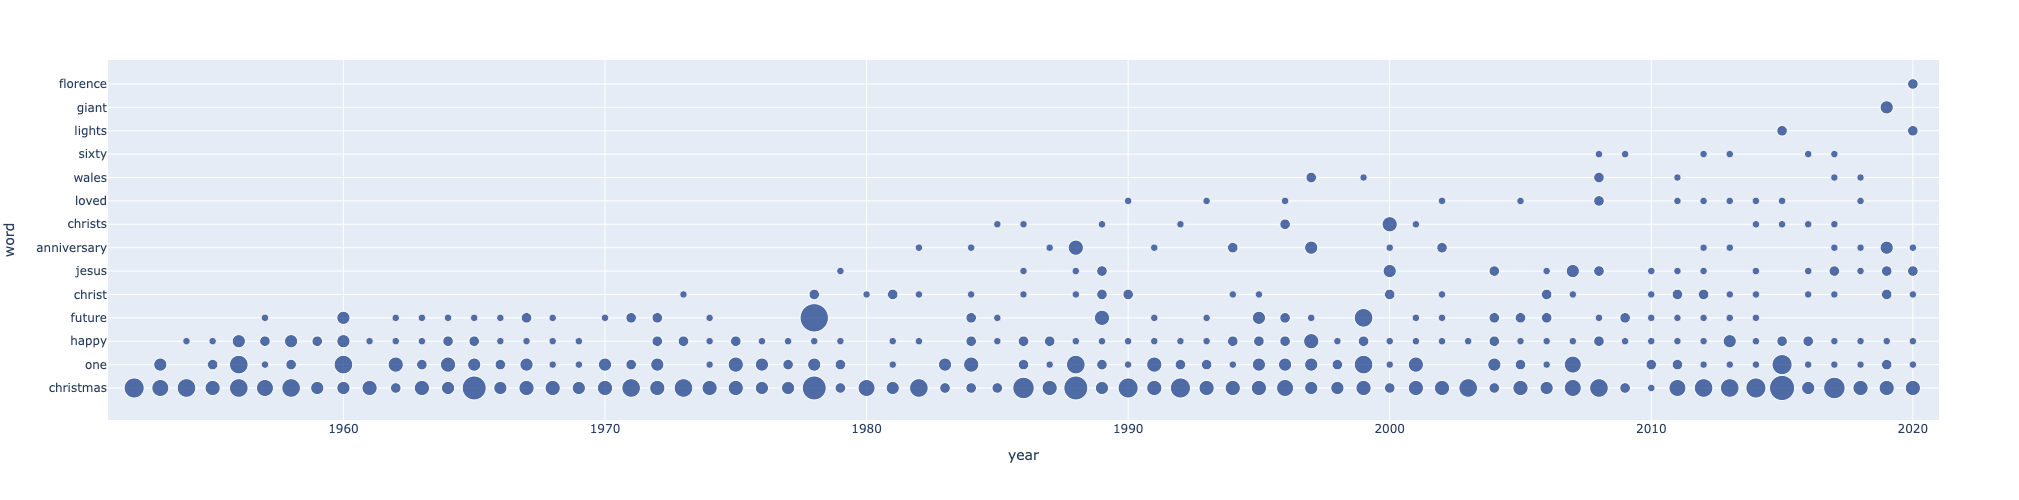

In [241]:
plot_heat(late_df.reset_index(), order=late_df.index.values)

In [242]:
early_df = agg_df.iloc[agg_df.groupby('year max')['counts'].idxmax()].set_index('word').drop('year min', axis=1)
# force_show_all(early_df)


In [243]:
old_len = len(early_df.index) + 1
while old_len - len(early_df.index) > 0:
    old_len = len(early_df.index)
    early_df = early_df[early_df['counts'].diff(1).fillna(1)> 0]
    
early_df

,year max,counts
word,,
promises,1952,2
conception,1955,3
voyage,1956,5
resources,1974,6
adventure,1978,9
brotherhood,1982,16
parts,1997,24
able,2008,30
britain,2011,37


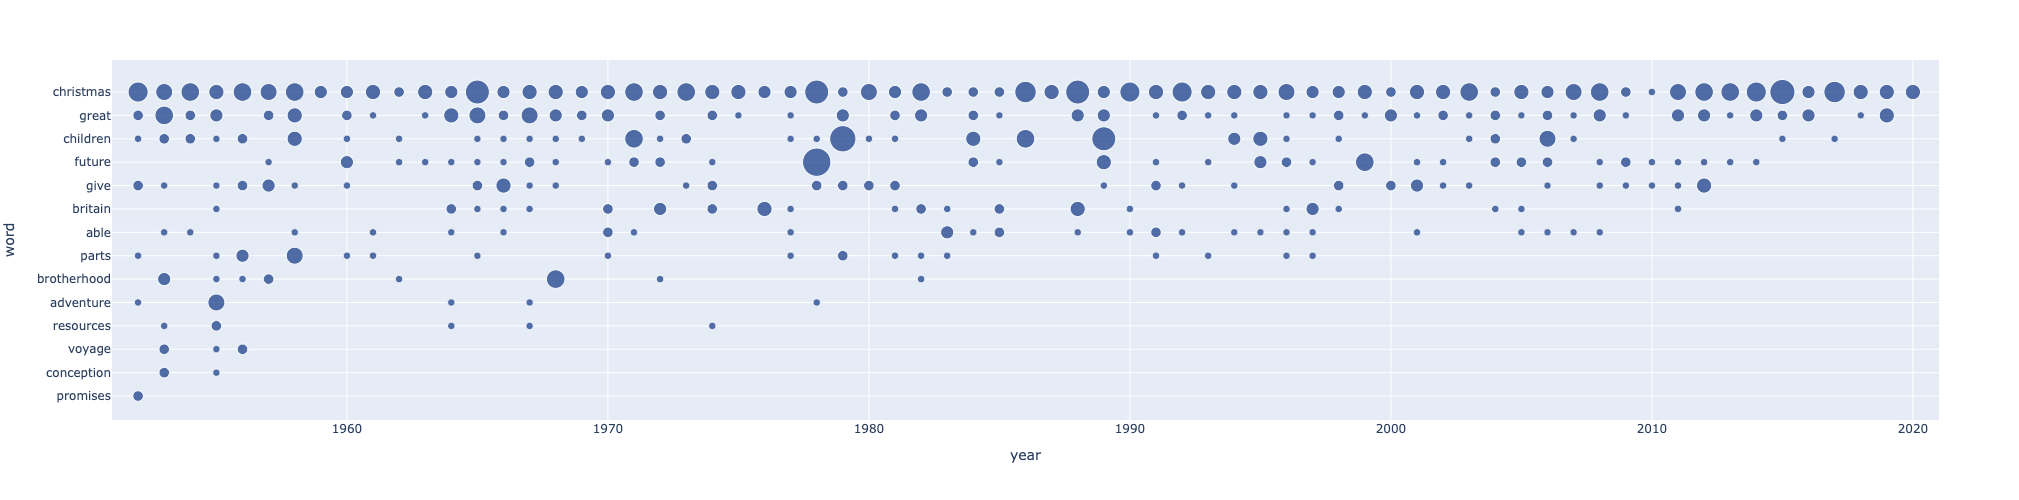

In [244]:
plot_heat(early_df.reset_index(), order=early_df.index.values)

In [250]:
force_show_all(agg_df[agg_df['year min'] == 2020])

agg_df[agg_df['word'] == 'kwanzaa']

,word,year min,year max,counts
191,amazing,2020,2020,1
570,cant,2020,2020,1
735,combatant,2020,2020,1
1178,distanced,2020,2020,1
1180,distancing,2020,2020,1
1198,diwali,2020,2020,1
1267,easter,2020,2020,1
1290,eid,2020,2020,1
1313,emerged,2020,2020,1
1524,familymembers,2020,2020,1


,word,year min,year max,counts


# watch yo profanity

In [31]:
df[df['word'] == 'ass']

,word,counts,year
8289,ass,1,1988


In [32]:
from profanity_check import predict_prob

In [277]:
prof_df = df[['word', 'counts','year']].groupby('word').sum().reset_index()

prof_df['profanity'] = prof_df['word'].apply(lambda x: predict_prob([x])[0])

prof_df.sort_values('profanity', ascending=False).head(20)

,word,counts,year,profanity
297,ass,1,1988,0.671707
3582,shut,2,3995,0.430420
1110,die,3,5942,0.347612
469,blow,1,1985,0.329478
3583,sick,7,13829,0.283717
541,bully,1,1990,0.269607
1906,hate,3,5919,0.265829
1081,destroy,1,1957,0.252384
2583,mouth,1,2001,0.251340
758,commit,1,2012,0.245369


# wordcloud

In [34]:
make_wordcloud(total_df.set_index('word').to_dict()['counts'], crown_mask).show()

NameError: name 'total_df' is not defined

In [ ]:
make_wordcloud(df[df['year'] == 1952][['word','counts']].groupby('word').sum().sort_values('counts', ascending=False).to_dict()['counts'], crown_mask).show()


In [ ]:
make_wordcloud(df[df['year'] == 2020][['word','counts']].groupby('word').sum().sort_values('counts', ascending=False).to_dict()['counts'], crown_mask).show()


# new plots

In [219]:
def plot_heat(words, start=1900, end=2050, bingo=False, title=False, order=False):
    
    plot_df = words_in(words, start=start, end=end)

    if bingo:
        plot_df = plot_df.append(pd.DataFrame(data={'year': bingo_WL(plot_df)[0], 'word':'BINGO', 'counts': plot_df['counts'].median()}))
    
    plot_df['bingo'] = plot_df['word'].apply(lambda x: 1 if x == 'BINGO' else 0)
    
    if title:
        bingo_success(['people'], percent=False)
        title = '{}, {}% ({}/{}) success rate'.format(title, round(bingo_success(words, percent=True), 2)*100, *bingo_success(words, percent=False))
        
    fig = px.scatter(plot_df,
                     x='year',
                     y='word',
                     size='counts',
                     color='bingo',
                     height=500,
                     width=1800,
                     color_continuous_scale=px.colors.diverging.Portland,
                     range_color=[0,1],
                     title = title,
                     range_x=[df['year'].min()-1, df['year'].max()+1])
    
    fig.update(layout_coloraxis_showscale=False)
    
    if isinstance(order, np.ndarray):
        fig.update_layout(yaxis=dict(type='category',
                                     categoryarray=order))

    return fig

In [79]:
all_total_plt = plot_heat(top_by_total().head(9),
                         bingo=True,
                         title = 'Bingo successes by all-time total') #, {}% ({}/{}) success rate'.format())
all_total_plt

AttributeError: 'bool' object has no attribute 'any'

In [37]:
py.plot(all_total_plt, filename = 'all_time_total', auto_open=True)


'https://plotly.com/~stomlins/16/'

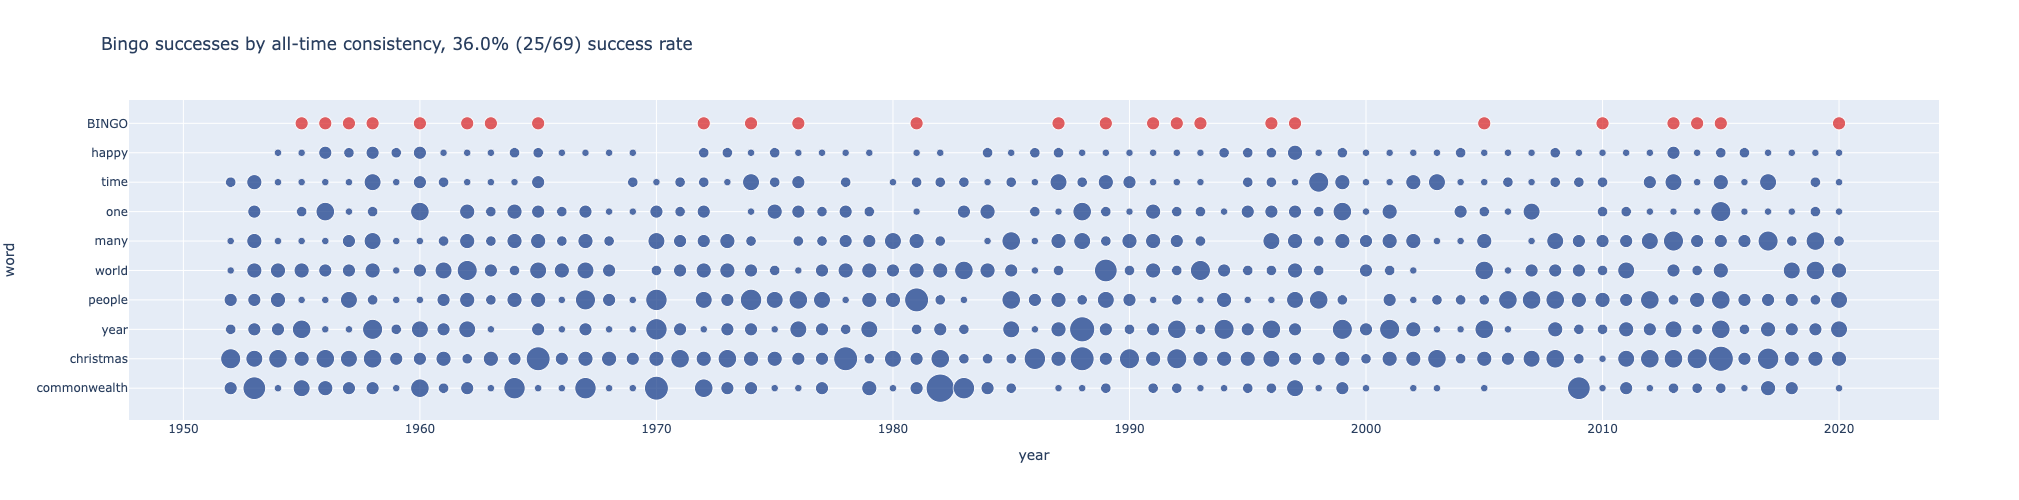

In [45]:
all_consist_plt = plot_heat(top_by_consist().head(9),
                            bingo=True,
                            title = 'Bingo successes by all-time consistency') #, {}% ({}/{}) success rate'.format())

all_consist_plt

In [46]:
py.plot(all_consist_plt, filename = 'all_consist', auto_open=True)


'https://plotly.com/~stomlins/18/'

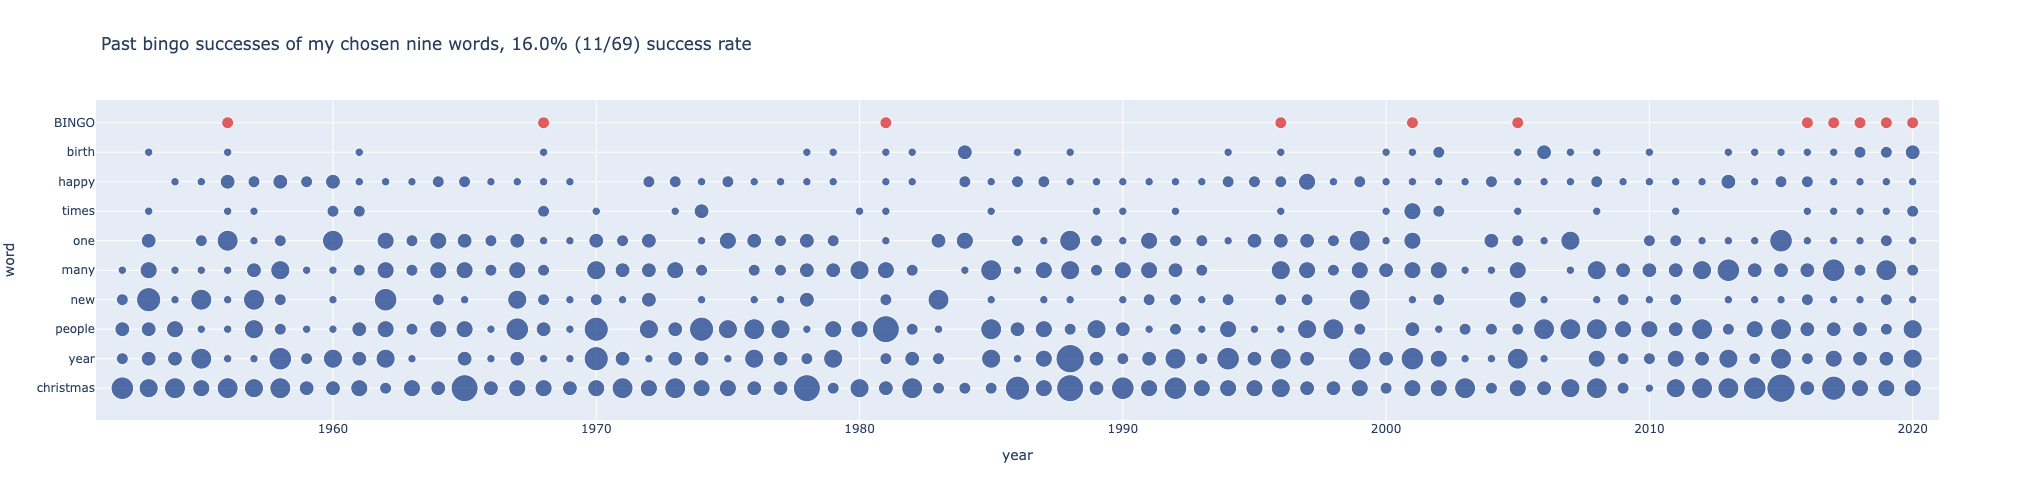

In [267]:
_2015_consist_plt = plot_heat(top_by_consist(start=2015, end=2020).head(9),
                              bingo=True,
                              title = 'Past bingo successes of my chosen nine words') #, {}% ({}/{}) success rate'.format())

_2015_consist_plt

In [268]:
py.plot(_2015_consist_plt, filename = 'my_bingo', auto_open=True)


'https://plotly.com/~stomlins/20/'

In [276]:
plot_heat(['reconciliation'])

df[df['word'] == 'reconciliation'].sum()

word      reconciliationreconciliationreconciliationreco...
counts                                                   24
year                                                  11969
dtype: object

# find best

In [40]:
res_df = pd.DataFrame(data={'what': ['top total','top 2000s','top 2010s', 'con total','con 2000s','con 2010s'],
                           'words': [top_by_total().head(9)['word'].values,
                                    top_by_total(start=2000).head(9)['word'].values,
                                    top_by_total(start=2010).head(9)['word'].values,
                                    top_by_consist().head(9).index.values,
                                    top_by_consist(start=2000).head(9).index.values,
                                    top_by_consist(start=2010).head(9).index.values,
                                    ]})

res_df

,what,words
0,top total,"[christmas, people, year, world, many, commonw..."
1,top 2000s,"[christmas, people, many, year, world, family,..."
2,top 2010s,"[christmas, many, people, year, world, family,..."
3,con total,"[christmas, people, year, happy, many, time, w..."
4,con 2000s,"[happy, christmas, many, people, year, time, g..."
5,con 2010s,"[many, year, christmas, one, happy, people, ne..."


In [41]:
res_df['total'] = res_df['words'].apply(lambda x: bingo_success(list(x), percent=True))
res_df['2000s'] = res_df['words'].apply(lambda x: bingo_success(list(x), start=2000, percent=True))
res_df['2010s'] = res_df['words'].apply(lambda x: bingo_success(list(x), start=2010, percent=True))

/opt/anaconda3/envs/personal2/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/anaconda3/envs/personal2/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/anaconda3/envs/personal2/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/anaconda3/envs/personal2/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/anaconda3/envs/personal2/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/anaconda3/envs/personal2/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/anaconda3/envs/personal2/lib/

In [42]:
res_df.sort_values(by=['2010s'], ascending=False)

,what,words,total,2000s,2010s
5,con 2010s,"[many, year, christmas, one, happy, people, ne...",0.347826,0.380952,0.727273
3,con total,"[christmas, people, year, happy, many, time, w...",0.362319,0.285714,0.454545
4,con 2000s,"[happy, christmas, many, people, year, time, g...",0.275362,0.380952,0.454545
0,top total,"[christmas, people, year, world, many, commonw...",0.304348,0.190476,0.363636
2,top 2010s,"[christmas, many, people, year, world, family,...",0.144928,0.190476,0.363636
1,top 2000s,"[christmas, people, many, year, world, family,...",0.188406,0.190476,0.181818


In [43]:
ar = np.empty([df['year'].max()-df['year'].min()+1., df['year'].max()-df['year'].min()+1])

for ia, a in enumerate(range(int(df['year'].min()), int(df['year'].max()+1))):
    for ib, b in enumerate(range(int(df['year'].min()), int(df['year'].max()+1))):
        
        print(ia, a, ib, b)
        
        ar[ia, ib] = bingo_success(top_by_consist(start=a).head(9), start=b)
                
ar
    

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
start = 2010
end = 2021
ar = np.empty([end-start, end-start])

for ia, a in enumerate(range(start, end-1)):
    for ib, b in enumerate(range(start, end)):
        
        print(ia, a, ib, b)
        
        ar[ia, ib] = bingo_success(top_by_consist(start=a, end=2019).head(9), start=b)
                
ar
    

In [ ]:
ar_df = pd.DataFrame(ar, columns=list(range(start, end)))
ar_df = ar_df.unstack().reset_index()
ar_df['level_1'] = ar_df['level_1'] + start
ar_df.columns = ['testing words on','getting words from', 'score']
ar_df


In [ ]:
px.scatter(ar_df, x='getting words from', y='testing words on', size='score', color='score', height=700, width=700)

In [ ]:
plot_heat(top_by_consist(start=2016).head(8),
          bingo=True,
          title = 'Bingo successes by consistency from 2016 onwards') #, {}% ({}/{}) success rate'.format())